![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/data-for-prediction-restaurant-rating/parsed.csv
/kaggle/input/data-for-prediction-restaurant-rating/all_in.csv
/kaggle/input/data-for-prediction-restaurant-rating/parser.py
/kaggle/input/data-for-prediction-restaurant-rating/preprocessing.ipynb


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Загрузим итоговые данные и проведем EDA (Разведочный анализ данных)
df = pd.read_csv('/kaggle/input/data-for-prediction-restaurant-rating/all_in.csv')
df.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,ID_TA,Main,alive,...,rest_number,is_capital,cuisines_number,population,city_square,net_rest,negative,neutra,positive,compound
29867,id_1183,Hamburg,['Indian'],1185.0,4.0,$$ - $$$,22.0,d799935,True,0,...,2915.0,0,1,1718187,755.09,1,0.0,0.573,0.427,0.7874
41120,id_1105,Lisbon,['usual'],2500.0,NaN,$*,2.0,d12437603,False,1,...,4690.0,1,1,547733,100.05,1,0.0,0.741,0.259,0.4215


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Rating               40000 non-null float64
Price Range          50000 non-null object
Number of Reviews    50000 non-null float64
ID_TA                50000 non-null object
Main                 50000 non-null bool
alive                50000 non-null int64
rating               50000 non-null float64
excelent             50000 non-null float64
very_good            50000 non-null float64
average              50000 non-null float64
poor                 50000 non-null float64
terrible             50000 non-null float64
time_between         50000 non-null float64
last_time_review     50000 non-null float64
text_reviews         41886 non-null object
rest_number          50000 non-null float64
is_capital           5

count    50000.000000
mean       116.720620
std        286.112464
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64


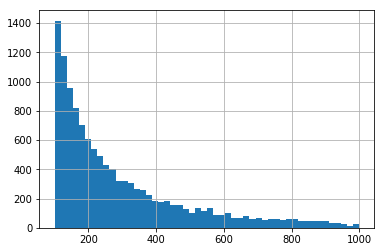

In [6]:
# Разобьем признаки на категориальные, числовые и бинарные. (некоторые - условно, их нужно еще доработать)
num_features = ['Number of Reviews', 'time_between', 'last_time_review', \
                'cuisines_number', 'population', 'city_square', 'Ranking', 'rating', 'rest_number',\
                'excelent', 'very_good', 'average', 'poor', 'terrible', \
                'negative', 'neutra', 'positive', 'compound']

cat_features = ['City', 'Cuisine Style', 'Price Range', 'text_reviews']
bin_features = ['alive', 'is_capital', 'net_rest']

other_features = ['Restaurant_id', 'ID_TA', 'Main', ]
# Числовые признаки
# 'Number of Reviews'
# Кол-во отзывов о ресторане
print(df['Number of Reviews'].describe())
df[(df['Number of Reviews'] > 100) & (df['Number of Reviews'] < 1000)]['Number of Reviews'].hist(bins=50)

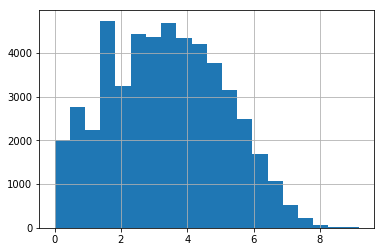

In [7]:
# Много ресторанов с маленьким количеством отзывов и наоборот мало с большим.
# Чтобы сгладить применим log
df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: np.log(x) if x != 0 else x)
df['Number of Reviews'].hist(bins=20)
# стало намного симпатичнее и ближе к норм распределению

count    50000.000000
mean      2027.352160
std       5345.107678
min          0.000000
25%          7.000000
50%         59.000000
75%        223.000000
max      17585.000000
Name: time_between, dtype: float64


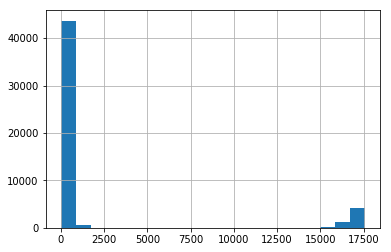

In [8]:
# 'time_between'
# время между отзывами
print(df['time_between'].describe())
#df[df['time_between'] < 0]['time_between'].hist(bins=20)
df['time_between'].hist(bins=20)

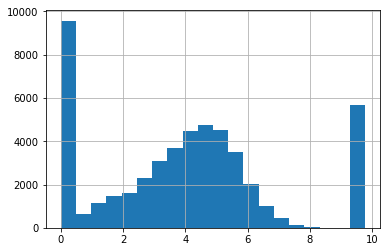

In [9]:
# сгладим этот некрасивый график логарифмом
df['time_between'] = df['time_between'].apply(lambda x: np.log(x) if x != 0 else x)
df['time_between'].hist(bins=20)

count    50000.000000
mean      4687.608640
std       6383.689645
min       1584.000000
25%       1681.000000
50%       1809.000000
75%       2263.000000
max      19172.000000
Name: last_time_review, dtype: float64


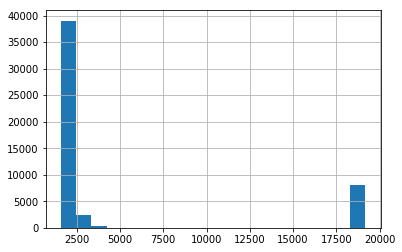

In [10]:
# 'last_time_review'
# время после последнего отзыва
print(df['last_time_review'].describe())
df['last_time_review'].hist(bins=20)

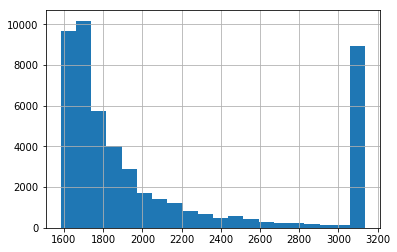

In [11]:
perc25 = df['last_time_review'].quantile(0.25)
perc75 = df['last_time_review'].quantile(0.75)
IQR = perc75 - perc25

df['last_time_review'] = df['last_time_review'].apply(lambda x : x if x < perc75 + 1.5*IQR else perc75 + 1.5*IQR)
df['last_time_review'].hist(bins=20)

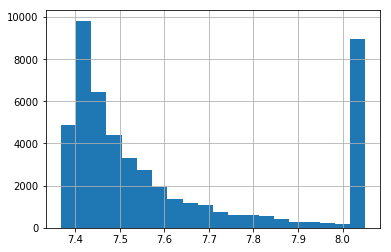

In [12]:
# сгладим этот некрасивый график логарифмом
df['last_time_review'] = df['last_time_review'].apply(lambda x: np.log(x) if x != 0 else x)
df['last_time_review'].hist(bins=20)
# распределение далеко от нормального. Посмотрим, возможно, в дальнейшем избавимся от данного столбца.

count    50000.000000
mean         2.709720
std          1.785744
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisines_number, dtype: float64


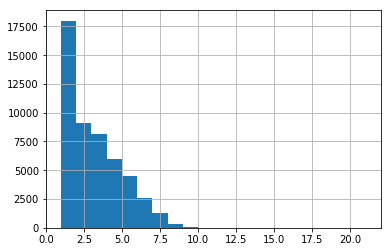

In [13]:
# 'cuisines_number'
# количество кухонь в ресторане
print(df['cuisines_number'].describe())
df['cuisines_number'].hist(bins=20)

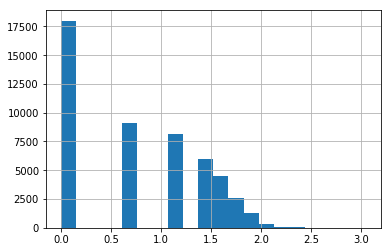

In [14]:
# сгладим этот некрасивый график логарифмом
df['cuisines_number'] = df['cuisines_number'].apply(lambda x: np.log(x) if x != 0 else x)
df['cuisines_number'].hist(bins=20)

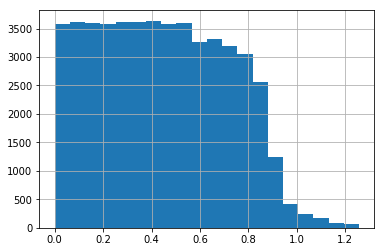

In [15]:
# добавим несколько признаков
# место ресторана в общем кол-ве ресторанов города
df['rest_in_rests'] = df['Ranking']/df['rest_number']
df['rest_in_rests'].hist(bins=20)

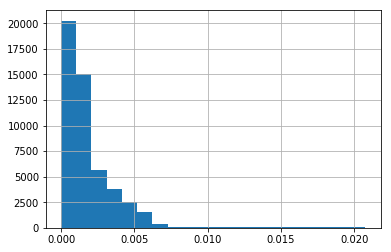

In [16]:
# место ресторана в населении города
df['rest_in_pop'] = df['Ranking']/df['population']
df['rest_in_pop'].hist(bins=20)

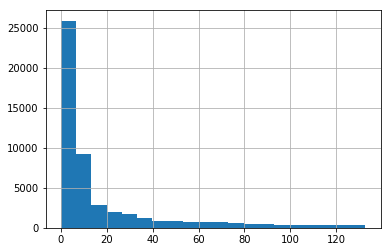

In [17]:
# место ресторана в площади города
df['rest_in_sq'] = df['Ranking']/df['city_square']
df['rest_in_sq'].hist(bins=20)

count    50000.000000
mean       556.243029
std        546.678679
min         15.930000
25%        105.400000
50%        368.000000
75%        891.680000
max       2586.400000
Name: city_square, dtype: float64


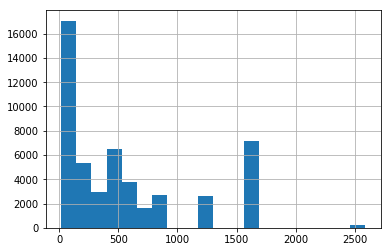

In [18]:
# 'city_square'
# площадь города
print(df['city_square'].describe())
df['city_square'].hist(bins=20)

count    50000.00000
mean         3.96267
std          0.54709
min          1.00000
25%          4.00000
50%          4.00000
75%          4.00000
max          5.00000
Name: rating, dtype: float64


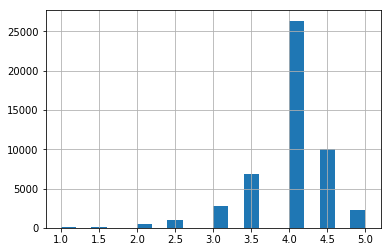

In [19]:
# rating
# rating - спарсенный рейтинг ресторанов (Nan были заменены медианой)
print(df['rating'].describe())
df['rating'].hist(bins=20)

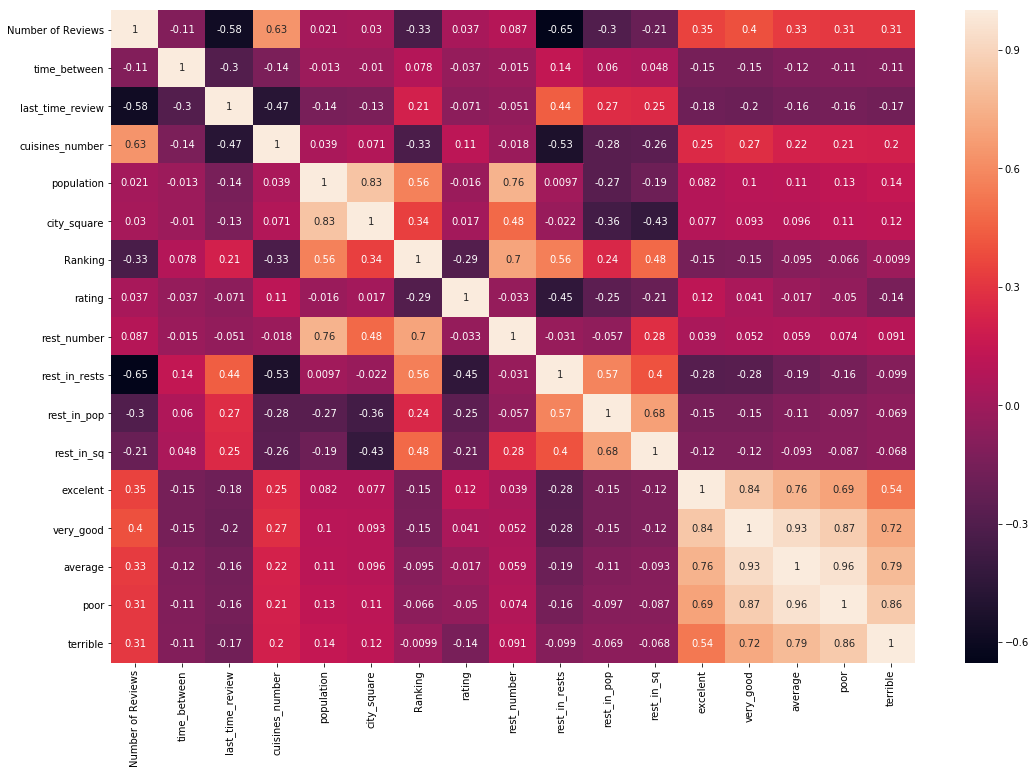

In [20]:
# итак числовые признаки:
num_features = ['Number of Reviews', 'time_between', 'last_time_review', \
                'cuisines_number', 'population', 'city_square', 'Ranking', 'rating', 'rest_number', \
                'rest_in_rests', 'rest_in_pop', 'rest_in_sq', 'excelent', 'very_good', 'average', 'poor', 'terrible']

# Посмотрим матрицу корреляций
correlation_matrix = df[num_features].corr()

# выведем на тепловую карту
plt.figure(figsize=(18,12))
sns.heatmap(correlation_matrix, annot=True)

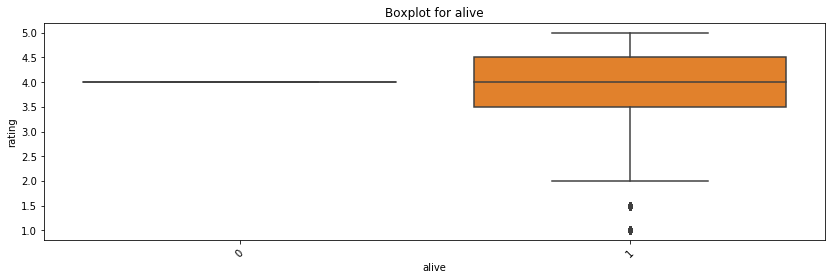

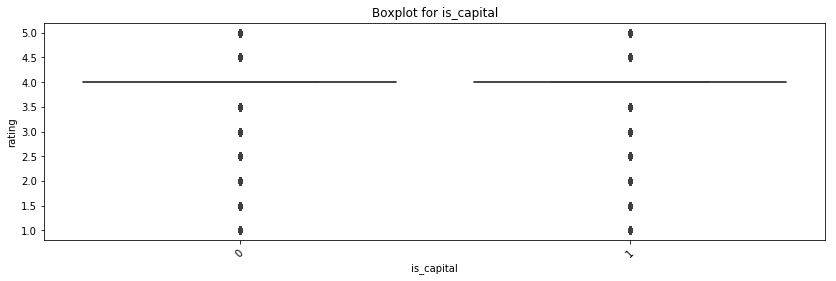

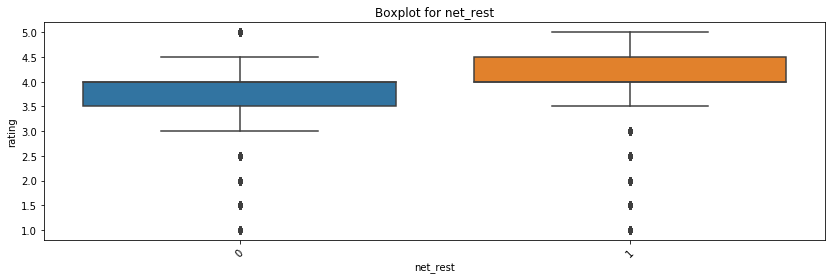

In [21]:
cat_features = ['City', 'Cuisine Style', 'Price Range']
bin_features = ['alive', 'is_capital', 'net_rest']
#Посмотрим боксплоты у бинарных признаков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating', 
                data=df[df[column].isin(df[column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in bin_features:
    get_boxplot(col)

In [22]:
# Сделаем столбцы из категориальных признаков
df = pd.get_dummies(df, columns=['City', 'Price Range'])

In [23]:
# С Cuisine Style чуть сложнее. Переведем в списки, добавим столбцы, заполним по наличию кухни в списке
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x[2:-2].split("', '"))
cuisines_list = []
for cuisines in df['Cuisine Style']:
    for cuisine in cuisines: 
        if cuisine not in cuisines_list:
            cuisines_list.append(cuisine)

for cuisine in cuisines_list:
    df = df.reindex(columns = np.append(df.columns.values, [cuisine]))


for cuisine in cuisines_list:    
    df[cuisine] = df['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0)

In [24]:
with pd.option_context('display.max_columns', None):
    display(df.sample(2))

,Restaurant_id,Cuisine Style,Ranking,Rating,Number of Reviews,ID_TA,Main,alive,rating,excelent,very_good,average,poor,terrible,time_between,last_time_review,text_reviews,rest_number,is_capital,cuisines_number,population,city_square,net_rest,negative,neutra,positive,compound,rest_in_rests,rest_in_pop,rest_in_sq,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,Price Range_$*,European,French,International,Asian,Nepali,Japanese,Sushi,Grill,Vegetarian Friendly,Vegan Options,Gluten Free Options,usual,German,Central European,Bar,Portuguese,Wine Bar,Italian,Pizza,Fast Food,Mediterranean,Spanish,Healthy,Cafe,Thai,Vietnamese,Pub,Chinese,British,Polish,Fusion,American,Diner,Dutch,Mexican,Venezuelan,South American,Soups,Belgian,Steakhouse,Latin,Barbecue,Argentinean,Irish,Seafood,Hungarian,Swiss,Contemporary,Greek,Central American,Indian,Middle Eastern,Turkish,Eastern European,Pakistani,Peruvian,Delicatessen,Swedish,Scandinavian,Tibetan,Korean,Southwestern,Czech,Slovenian,Balti,Street Food,Quick Bites,Basque,Brew Pub,Caribbean,Austrian,Moroccan,Halal,Lebanese,Russian,African,Ethiopian,Egyptian,Danish,Brazilian,Ecuadorean,Israeli,Kosher,Gastropub,Australian,Singaporean,Malaysian,Minority Chinese,Scottish,Arabic,Ukrainian,Chilean,Mongolian,Emilian,Cuban,Dessert,Persian,Croatian,Filipino,Indonesian,Colombian,Jamaican,Norwegian,Hawaiian,Bakeries,Deli,Armenian,Taiwanese,Bangladeshi,Cajun & Creole,Sri Lankan,Cambodian,Albanian,New Zealand,Central Asian,Specialty Food Market,Tunisian,Romanian,Georgian,Romagna,Polynesian,Catalan,Azerbaijani,Caucasian,Afghani,Uzbek,Canadian,Romana,Beer restaurants,Salvadoran,Yunnan,Native American,Dining bars,Xinjiang,Burmese,Lombard,Northern-Italian,Fujian,Neapolitan,Campania,Welsh,Lazio,Cantonese,Beijing Specialties,Latvian,Japanese Fusion,Sardinian,Southern-Italian
23460,id_1509,"[Steakhouse, Pizza, Cafe, Street Food, Italian]",1511.0,3.5,3.637586,d1021090,True,1,4.0,1.0,4.0,1.0,2.0,0.0,4.204693,7.658228,"'Very pricey', 'Far below expectations'",2460.0,1,1.609438,3168846,412.00,1,0.0,1.000,0.000,0.0000,0.614228,0.000477,3.667476,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24078,id_354,"[European, Vegetarian Friendly, Vegan Options]",355.0,4.0,2.484907,d13170250,True,1,4.0,49.0,31.0,16.0,18.0,8.0,1.386294,7.402452,"'Definitely Yes!', 'Nice veggie food, ok atmos...",1399.0,1,1.098612,574579,715.48,1,0.0,0.334,0.666,0.7901,0.253753,0.000618,0.496170,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
df.last_time_review = 0

In [26]:
# оставляем в табличке для теста только рабочие столбцы 
df_for_test = df.drop(['Restaurant_id', 'Cuisine Style', 'ID_TA', 'text_reviews', 'Rating'], axis = 1)
# df_for_test = df.drop(['Restaurant_id', 'Cuisine Style', 'ID_TA', 'text_reviews', 'Rating', 'last_time_review'], axis = 1)
scaler = MinMaxScaler()
df_for_test[num_features] = scaler.fit_transform(df_for_test[num_features])


# Готовим данные
X = df_for_test[df_for_test['Main']]
y = df[df['Main']]['Rating']

<!-- # DATA -->

In [27]:
# DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [28]:
# df_train.info()

In [29]:
# df_train.head(5)

In [30]:
# df_test.info()

In [31]:
# df_test.head(5)

In [32]:
# sample_submission.head(5)

In [33]:
# sample_submission.info()

In [34]:
# # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [35]:
# data.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [36]:
# data.sample(5)

In [37]:
# data.Reviews[1]

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [38]:
# # Для примера я возьму столбец Number of Reviews
# data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [39]:
# data['Number_of_Reviews_isNAN']

In [40]:
# # Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
# data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [41]:
# data.nunique(dropna=False)

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [42]:
# # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [43]:
# data.head(5)

In [44]:
# data.sample(5)

#### Возьмем следующий признак "Price Range".

In [45]:
# data['Price Range'].value_counts()

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [46]:
# Ваша обработка 'Price Range'

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [47]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [48]:
# plt.rcParams['figure.figsize'] = (10,7)
# df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [49]:
# df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [50]:
# df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [51]:
# # посмотрим на топ 10 городов
# for x in (df_train['City'].value_counts())[0:10].index:
#     df_train['Ranking'][df_train['City'] == x].hist(bins=100)
# plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [52]:
# df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [53]:
# df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [54]:
# df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [55]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [56]:
# # на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [57]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [58]:
# df_preproc = preproc_data(data)
# df_preproc.sample(10)

In [59]:
# df_preproc.info()

In [60]:
# # Теперь выделим тестовую часть
# train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
# test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

# y = train_data.Rating.values            # наш таргет
# X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [61]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [62]:
# проверяем
# test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [63]:
# Импортируем необходимые библиотеки:
# from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
# from sklearn import metrics # инструменты для оценки точности модели

In [64]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [65]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [66]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17431124999999997


In [67]:
# Округлим результаты работы модели:
def round_to_polovina(row):
    return (round(row*2.0)/2)

new_round = np.vectorize(round_to_polovina)
y_pred_round = new_round(model.predict(X_test))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.1414375


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


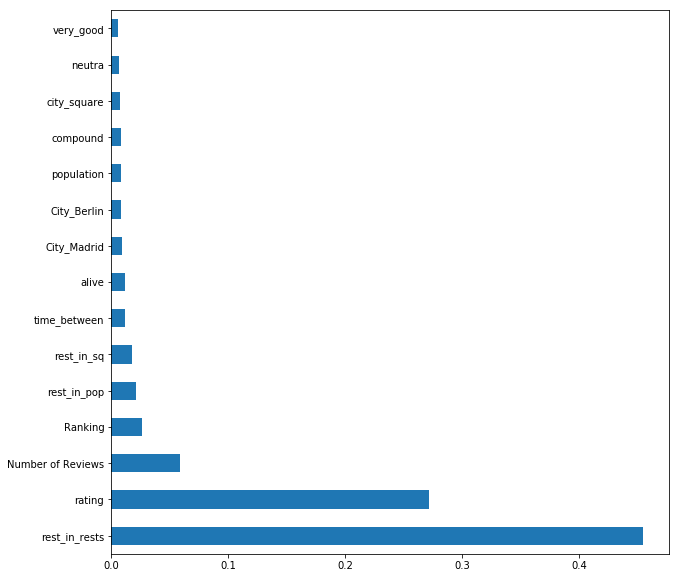

In [68]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [69]:
# test_data.sample(10)

In [70]:
# test_data = test_data.drop(['Rating'], axis=1)

In [71]:
# sample_submission

In [72]:
# predict_submission = model.predict(test_data)

In [73]:
# predict_submission

In [74]:
# sample_submission['Rating'] = predict_submission
# sample_submission.to_csv('submission.csv', index=False)
# sample_submission.head(10)

In [75]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
kaggle_df = df_for_test[~df_for_test['Main']]
y_pred = model.predict(kaggle_df)

submission = pd.DataFrame({
        "Restaurant_id": df[~df['Main']]['Restaurant_id'],
        "Rating": y_pred
    })
#submission['Restaurant_id']=submission['Restaurant_id'].astype('str')

submission['Rating'] = submission['Rating'].apply(round_to_polovina)
# submission.to_csv('/kaggle/working/submission.csv', index=False)
submission.to_csv('submission.csv', index=False)
submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


,Restaurant_id,Rating
3441,id_1423,4.0
5093,id_4337,3.5
5553,id_4323,4.0
6034,id_7376,5.0
11346,id_704,3.5
...,...,...
49995,id_9995,4.5
49996,id_9996,4.0
49997,id_9997,3.0
49998,id_9998,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
